# Canadian Wild Fire Analysis 1980-2020

By Navkaran Bola

Import necessary libraries.

In [398]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from scipy.stats.stats import pearsonr
%matplotlib inline

Following steps will read and examine the CSV.

In [386]:
df = pd.read_csv('NFDB_point_20210916.csv')

In [387]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417133 entries, 0 to 417132
Data columns (total 27 columns):
FID           417133 non-null int64
SRC_AGENCY    417133 non-null object
FIRE_ID       416968 non-null object
FIRENAME      417132 non-null object
LATITUDE      417133 non-null float64
LONGITUDE     417133 non-null float64
YEAR          417133 non-null int64
MONTH         417133 non-null int64
DAY           417133 non-null int64
REP_DATE      413421 non-null object
ATTK_DATE     27937 non-null object
OUT_DATE      210237 non-null object
DECADE        417133 non-null object
SIZE_HA       417133 non-null float64
CAUSE         416933 non-null object
PROTZONE      416123 non-null object
FIRE_TYPE     417133 non-null object
MORE_INFO     417133 non-null object
CFS_REF_ID    417133 non-null object
CFS_NOTE1     417133 non-null object
CFS_NOTE2     417133 non-null object
ACQ_DATE      406528 non-null object
SRC_AGY2      417133 non-null object
ECOZONE       417133 non-null int64
ECOZ

In [388]:
df.head()

,FID,SRC_AGENCY,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,...,MORE_INFO,CFS_REF_ID,CFS_NOTE1,CFS_NOTE2,ACQ_DATE,SRC_AGY2,ECOZONE,ECOZ_REF,ECOZ_NAME,ECOZ_NOM
0,0,BC,1953-G00041,,59.963,-128.172,1953,5,26,1953-05-26 00:00:00,...,,BC-1953-1953-G00041,,,2020-05-05 00:00:00,BC,12,12,Boreal Cordillera,CordillCre boreale
1,1,BC,1950-R00028,,59.318,-132.172,1950,6,22,1950-06-22 00:00:00,...,,BC-1950-1950-R00028,,,2020-05-05 00:00:00,BC,12,12,Boreal Cordillera,CordillCre boreale
2,2,BC,1950-G00026,,59.876,-131.922,1950,6,4,1950-06-04 00:00:00,...,,BC-1950-1950-G00026,,,2020-05-05 00:00:00,BC,12,12,Boreal Cordillera,CordillCre boreale
3,3,BC,1951-R00097,,59.760,-132.808,1951,7,15,1951-07-15 00:00:00,...,,BC-1951-1951-R00097,,,2020-05-05 00:00:00,BC,12,12,Boreal Cordillera,CordillCre boreale
4,4,BC,1952-G00116,,59.434,-126.172,1952,6,12,1952-06-12 00:00:00,...,,BC-1952-1952-G00116,,,2020-05-05 00:00:00,BC,12,12,Boreal Cordillera,CordillCre boreale


# Data Pre-Processing

## Missing Values 

Let's first visualize our missing values and see what our raw data looks like. We can cleanse our data by dropping columns that have an excessive number of missing values prior to our analysis. 

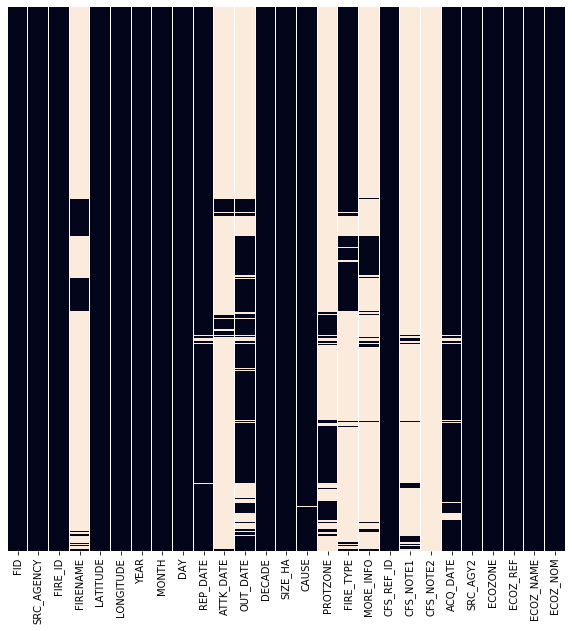

In [436]:
plt.subplots(figsize=(10,10))
sns.heatmap(df.isnull() | df.eq(' '),cbar=False,yticklabels=False); # visualize both empty strings and missing values in dataset

There are a number of columns that have missing values. We will use a threshold of 40% where columns that have more than 40% of their values missing will be dropped.

In [437]:
missing_values = [column for column in df.columns[df.eq(' ').mean()>0.4]] + [column for column in df.columns[df.isnull().mean()>0.4]] 
missing_values

['FIRENAME',
 'PROTZONE',
 'FIRE_TYPE',
 'MORE_INFO',
 'CFS_NOTE1',
 'CFS_NOTE2',
 'ATTK_DATE',
 'OUT_DATE']

Let's drop these columns and take a look at our new data frame! 

In [383]:
df.drop(missing_values,axis=1,inplace=True)

In [384]:
df.head()

,FID,SRC_AGENCY,FIRE_ID,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,DECADE,SIZE_HA,CAUSE,CFS_REF_ID,ACQ_DATE,SRC_AGY2,ECOZONE,ECOZ_REF,ECOZ_NAME,ECOZ_NOM
0,0,BC,1953-G00041,59.963,-128.172,1953,5,26,1953-05-26 00:00:00,1950-1959,8.0,H,BC-1953-1953-G00041,2020-05-05 00:00:00,BC,12,12,Boreal Cordillera,CordillCre boreale
1,1,BC,1950-R00028,59.318,-132.172,1950,6,22,1950-06-22 00:00:00,1950-1959,8.0,L,BC-1950-1950-R00028,2020-05-05 00:00:00,BC,12,12,Boreal Cordillera,CordillCre boreale
2,2,BC,1950-G00026,59.876,-131.922,1950,6,4,1950-06-04 00:00:00,1950-1959,12949.9,H,BC-1950-1950-G00026,2020-05-05 00:00:00,BC,12,12,Boreal Cordillera,CordillCre boreale
3,3,BC,1951-R00097,59.760,-132.808,1951,7,15,1951-07-15 00:00:00,1950-1959,241.1,H,BC-1951-1951-R00097,2020-05-05 00:00:00,BC,12,12,Boreal Cordillera,CordillCre boreale
4,4,BC,1952-G00116,59.434,-126.172,1952,6,12,1952-06-12 00:00:00,1950-1959,1.2,H,BC-1952-1952-G00116,2020-05-05 00:00:00,BC,12,12,Boreal Cordillera,CordillCre boreale


## Reshaping Data

So far so good! We will now narrow our focus by creating a data frame that only looks at data between 1980-2020.

In [99]:
df2 = df[df["YEAR"] > 1979].reset_index(drop=True)

Later in our analysis, we will need to take a look at the different causes of forest fires. However, the data we currently have uses shortened abbreviations for each cause which isn't entirely clear to the user. We will need to impute values that are a bit more legible.

H = Human

L = Lightning

U = Unknown

H-PB = Human Prescribed Burn 

RE = Restart (Restart of a wildfire thought to be previously extinguished)

In [100]:
df2['CAUSE'].value_counts()

H       159964
L       139795
U         8364
H-PB       305
RE          74
Name: CAUSE, dtype: int64

In [102]:
df2.loc[df2['CAUSE'] == 'H','CAUSE'] = 'Human'
df2.loc[df2['CAUSE'] == 'L','CAUSE'] = 'Lightning'
df2.loc[df2['CAUSE'] == 'U','CAUSE'] = 'Unknown'
df2.loc[df2['CAUSE'] == 'H-PB','CAUSE'] = 'Human Prescribed Burn'
df2.loc[df2['CAUSE'] == 'RE','CAUSE'] = 'Restart'
df2['CAUSE'].value_counts()

Human                    159964
Lightning                139795
Unknown                    8364
Human Prescribed Burn       305
Restart                      74
Name: CAUSE, dtype: int64

# Exploratory Analysis

With the data cleaned up, we can now begin to visualize our data. To start, let's get a high-level overview of the fires before getting more granular with our analysis. We will plot both the number of fires nationwide and the total area burned between 1980-2020. 

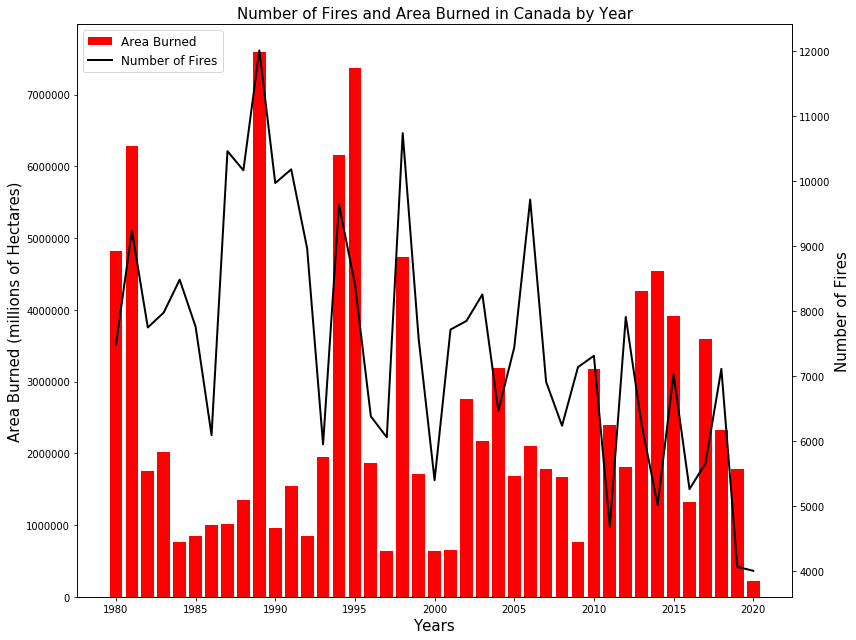

In [460]:
fires = df2.groupby(['YEAR'])['YEAR'].count().reset_index(name='COUNT')
area = df2.groupby(['YEAR'])['SIZE_HA'].sum().round().reset_index(name='SUM')

fig, ax1 = plt.subplots(figsize=(12,9))

ax1.bar(area['YEAR'],area['SUM'],color='red',label='Area Burned')
ax2 = ax1.twinx()
ax2.plot(fires['YEAR'],fires['COUNT'],color='black',label ='Number of Fires',linewidth=2)
ax1.set_title('Number of Fires and Area Burned in Canada by Year',fontsize=15)
ax1.set_xlabel('Years',fontsize=15)
ax1.set_ylabel('Area Burned (millions of Hectares)',fontsize=15)
ax2.set_ylabel('Number of Fires',fontsize=15)

plt.tight_layout()
fig.legend(loc="upper left",bbox_to_anchor=(0,1),bbox_transform=ax1.transAxes,fontsize=12);


Looking at the plot above, I was curious to know whether or not there was any correlation between the number of fires and the total area burned for a given year. To answer this question, lets plot the two variables and determine the Pearson Correlation Coefficient(r).

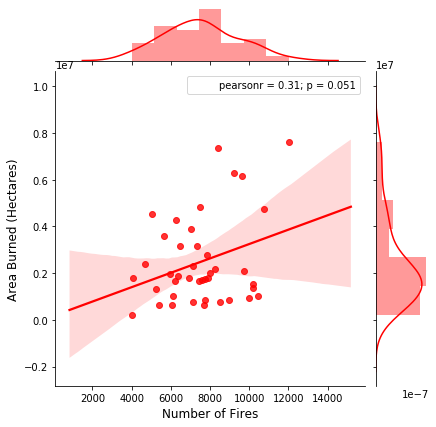

In [459]:
fire_area_merged = pd.merge(fires,area,how='inner',on=['YEAR'])
plot = sns.jointplot(x='COUNT', y='SUM',data=fire_area_merged , kind="reg",color='red')
plot.annotate(pearsonr);
plt.xlabel('Number of Fires',fontsize=12)
plt.ylabel('Area Burned (Hectares)',fontsize=12);

With a weak positive correlation coefficient of 0.31, we can conclude that there is not a strong correlation between the number of fires and total area burned. Additionally, with a two-tailed p-value of 0.05, there is not a statistically significant correlation between the two variables. 

With the correlation question settled, my next question was what was exactly causing these fires to ignite in the first place? Let's breakdown the different causes of wildfires nationwide. 

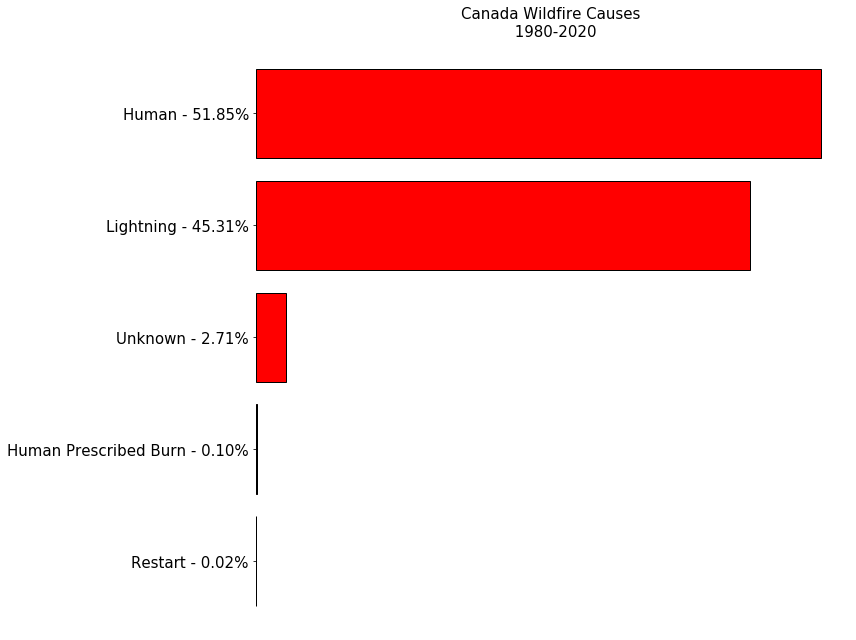

In [373]:
fire_cause = df2.groupby(['CAUSE'])['CAUSE'].count().reset_index(name='COUNT').sort_values(by=['COUNT'])

total = sum(fire_cause['COUNT'])
x = fire_cause['CAUSE']
y = fire_cause['COUNT']
percent = y/total*100

new_labels = [i+' - {:.2f}%'.format(j) for i,j in zip(x,percent)]

fig, ax = plt.subplots(figsize=(12,9))
plt.barh(x,y,color = 'r',edgecolor = 'black')
plt.yticks(range(len(x)),new_labels,fontsize=15)

for spine in ax.spines.values():
    spine.set_visible(False)
    
ax.axes.get_xaxis().set_visible(False)
ax.tick_params(axis='y',left=True)

plt.title('Canada Wildfire Causes \n 1980-2020',fontsize=15)
plt.tight_layout()

The graph above tells us that majority of wildfires nationwide are the result of human activity and lightning. However, between human activity and lightning, which cause proves to be the most destructive in terms of area burned?

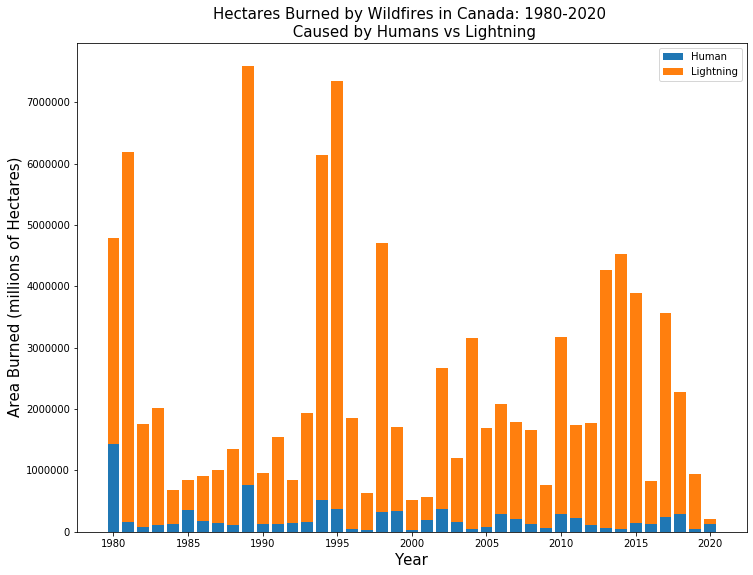

In [443]:
size_cause = df2.groupby(['YEAR','CAUSE'])['SIZE_HA'].sum(axis=0).round().unstack()
size_cause.drop(['Human Prescribed Burn','Restart','Unknown'],axis=1,inplace=True)

x = size_cause.index

y1 = size_cause['Human'].values
y2 = size_cause['Lightning'].values

plt.subplots(figsize=(12,9))
plt.bar(x,y1,label = 'Human')
plt.bar(x,y2,bottom = y1, label = 'Lightning')

plt.title('Hectares Burned by Wildfires in Canada: 1980-2020 \n Caused by Humans vs Lightning',fontsize=15)
plt.xlabel('Year',fontsize =15)
plt.ylabel('Area Burned (millions of Hectares)',fontsize =15)

plt.legend();

Even though human caused fires (51.85%) make up a slightly larger portion of total fires nationwide compared to lightning caused fires (45.31%), the plot above clearly shows that fires caused by lightning are much more destructive.

# Folium Heatmap Visualization

Now let's take a look nationwide of wildfire hotspots by year. The function below will receive user input between the time range and return a map of wild fire points recorded across the country. We can gain a better understanding of what areas in the countries were hardest hit for a given year. 

In [457]:
def wildfire_year():
    
    year = int(input('Input a Year: '))
    df3 = df2[df2["YEAR"] == year]
    locations = df3[['LATITUDE','LONGITUDE']]
    locationlist = locations.values.tolist()

    m = folium.Map(location=[56.1304, -106.3468],zoom_start=4)
    
    HeatMap(locationlist,min_opacity=0.2,radius=10,blur=8).add_to(m)
    
    return m  

In [458]:
wildfire_year()

Input a Year: 2014
